In [ ]:
!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata
!pip3 install torch torchaudio torchvision torchtext torchdata

Found existing installation: torch 2.0.1+cu118
Uninstalling torch-2.0.1+cu118:
  Successfully uninstalled torch-2.0.1+cu118
Found existing installation: torchaudio 2.0.2+cu118
Uninstalling torchaudio-2.0.2+cu118:
  Successfully uninstalled torchaudio-2.0.2+cu118
Found existing installation: torchvision 0.15.2+cu118
Uninstalling torchvision-0.15.2+cu118:
  Successfully uninstalled torchvision-0.15.2+cu118
Found existing installation: torchtext 0.15.2
Uninstalling torchtext-0.15.2:
  Successfully uninstalled torchtext-0.15.2
Found existing installation: torchdata 0.6.1
Uninstalling torchdata-0.6.1:
  Successfully uninstalled torchdata-0.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn.functional as F
import warnings

from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast
from tqdm import tqdm

from torch.cuda.amp import GradScaler
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [ ]:
from torch import nn

class LeNet(nn.Module):

    def __init__(self):

        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.50),
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
            nn.ReLU(),
        )

    def forward(self, x):

        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)

        return x

In [ ]:
from torch import nn

class AlexNet(nn.Module):

    def __init__(self):

        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):

        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [ ]:
from torch import nn

class VGG(nn.Module):

    def __init__(self):

        super(VGG, self).__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_5 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.classifier = nn.Sequential(
            nn.Linear(512*3*3, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, 10),
        )

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = x.view(x.size(0), -1)

        x = self.classifier(x)

        return x

In [ ]:
def train_steps(epoch, net, train_loader, criterion, optimizer, scaler):
    num_samples, loss_train = 0, 0

    tgs_i = [] # Inputs targets
    preds_i = [] # Predictions

    net = net.train()
    for train in tqdm(train_loader, desc = 'Steps Epoch {}'.format(epoch+1)):
        inputs, labels = train
        inputs, labels = inputs.to(device), labels.to(device) # Put on GPU

        with autocast():
            outputs = net(inputs) # Forward
            loss = criterion(outputs, labels) # Loss function

        scaler.scale(loss).backward() # Backward

        # Optimizer
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        # Calculate performance measures
        num_samples += labels.size(0)
        loss_train += loss.item()

        tgs_i.extend(label.item() for label in labels)
        sms = F.softmax(outputs, dim = 1)
        preds = torch.argmax(sms, 1)
        preds_i.extend(pred.item() for pred in preds)

    acc_train = 100*(accuracy_score(tgs_i, preds_i))
    loss_train = loss_train/num_samples

    return acc_train, loss_train

#%% VALIDATION AND TEST STEPS LOOPS

def evaluate_steps(net, set_loader, criterion):
    num_samples, loss_set = 0, 0

    tgs_i = [] # Inputs targets
    preds_i = [] # Predictions

    with torch.no_grad(): # Disables gradient calculation
        net = net.eval()
        for set in set_loader:
            inputs, labels = set
            inputs, labels = inputs.to(device), labels.to(device) # Put on GPU

            outputs = net(inputs) # Forward
            loss = criterion(outputs, labels) # Loss function

            # Calculate performance metrics
            num_samples += labels.size(0)
            loss_set += loss.item()

            tgs_i.extend(label.item() for label in labels)
            sms = F.softmax(outputs, dim = 1)
            preds = torch.argmax(sms, 1)
            preds_i.extend(pred.item() for pred in preds)

    acc_set = 100*(accuracy_score(tgs_i, preds_i))
    loss_set = loss_set/num_samples

    return acc_set, loss_set

In [ ]:

import matplotlib as mpl
import numpy as np
import os

from decimal import Decimal
from matplotlib import pyplot as plt

#%% LOGGER CLASS
'''
Store and print all performance measures
'''

class Logger:
    def __init__(self):
        self.acc_train = []
        self.loss_train = []

        self.acc_test = []
        self.loss_test = []

    def get_logs(self):
        return self.acc_train, self.loss_train, self.acc_test, self.loss_test

    def restore_logs(self, logs):
        self.acc_train, self.loss_train, self.acc_test, self.loss_test = logs

    def save_plts(self, path):
        # Style
        mpl.style.use('seaborn')
        plt.rcParams.update({
            'text.usetex': False,
            'font.family': 'serif',
            'font.serif': ['Times']
         })

        # Hyper-parameters

        num_epochs = len(self.acc_train)

        acc_path = os.path.join(path, 'accuracy.pdf')
        loss_path = os.path.join(path, 'loss.pdf')

        # Max value of training and test loss
        max_loss_train = max(self.loss_train)
        max_loss_test = max(self.loss_test)

        x_s = np.arange(1, num_epochs+1, 1) # Abscissa

        #%% ACCURACY PLOT

        _, ax = plt.subplots(1, figsize = (40, 40))
        plt.plot(x_s, self.acc_train, label = 'Training Acc.', color = 'red')
        plt.plot(x_s, self.acc_test, label = 'Test Acc.', color = 'blue')

        plt.grid(True)

        # x-axis configuration
        plt.xlabel('Epochs', labelpad = 72, fontsize = 72)
        xticks = np.arange(0, num_epochs+1, num_epochs//5)
        plt.xticks(xticks, ['{}'.format(x) for x in xticks], fontsize = 60)
        plt.xlim(1, ax.get_xticks()[-1])

        # y-axis configuration
        plt.ylabel('Accuracy', labelpad = 72, fontsize = 72)
        yticks = np.arange(0, 101, 20)
        plt.yticks(yticks,  ['{}'.format(y) + r'%' for y in yticks], fontsize = 60)
        plt.ylim(0, 100)

        plt.legend(loc = 'best', fontsize = 72, frameon = True)

        plt.savefig(acc_path, bbox_inches = 'tight', pad_inches = 0)

        #%% LOSS PLOT

        _, ax = plt.subplots(1, figsize = (40, 40))
        plt.plot(x_s, self.loss_train, label = 'Training Loss', color = 'red')
        plt.plot(x_s, self.loss_test, label = 'Test Loss', color = 'green')

        plt.grid(True, color = 'white')

        # x-axis configuration
        plt.xlabel('Epochs', labelpad = 72, fontsize = 72)
        xticks = np.arange(0, num_epochs+1, num_epochs//5)
        plt.xticks(xticks, ['{}'.format(x) for x in xticks], fontsize = 60)
        plt.xlim(1, ax.get_xticks()[-1])

        # y-axis configuration
        plt.ylabel('Loss', labelpad = 72, fontsize = 72)
        if max_loss_train >= max_loss_test:
            yticks = np.arange(0, max_loss_train + max_loss_train/5, max_loss_train/5)
        else:
            yticks = np.arange(0, max_loss_test + max_loss_test/5, max_loss_test/5)
        plt.yticks(yticks, ['{:.2E}'.format(Decimal(y)) for y in yticks], fontsize = 60)
        plt.ylim(0, ax.get_yticks()[-1])

        plt.legend(loc = 'best', fontsize = 72, frameon = True)

        plt.savefig(loss_path, bbox_inches = 'tight', pad_inches = 0)

VGG(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(


Steps Epoch 1: 100%|██████████| 235/235 [02:01<00:00,  1.94it/s]


Epoch 1 | Train Acc. 76.98% | Test Acc. 87.59% | Train Loss 0.00251% | Test Loss 0.00137%



Steps Epoch 2: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 2 | Train Acc. 88.48% | Test Acc. 87.52% | Train Loss 0.00131% | Test Loss 0.00134%



Steps Epoch 3: 100%|██████████| 235/235 [02:02<00:00,  1.91it/s]


Epoch 3 | Train Acc. 91.89% | Test Acc. 92.01% | Train Loss 0.00089% | Test Loss 0.00088%



Steps Epoch 4: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 4 | Train Acc. 93.38% | Test Acc. 90.52% | Train Loss 0.00073% | Test Loss 0.00106%



Steps Epoch 5: 100%|██████████| 235/235 [02:03<00:00,  1.91it/s]


Epoch 5 | Train Acc. 94.37% | Test Acc. 91.15% | Train Loss 0.00063% | Test Loss 0.00102%



Steps Epoch 6: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 6 | Train Acc. 95.36% | Test Acc. 91.89% | Train Loss 0.00051% | Test Loss 0.00100%



Steps Epoch 7: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 7 | Train Acc. 96.23% | Test Acc. 90.74% | Train Loss 0.00041% | Test Loss 0.00117%



Steps Epoch 8: 100%|██████████| 235/235 [02:02<00:00,  1.91it/s]


Epoch 8 | Train Acc. 97.03% | Test Acc. 92.35% | Train Loss 0.00033% | Test Loss 0.00113%



Steps Epoch 9: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 9 | Train Acc. 97.57% | Test Acc. 92.84% | Train Loss 0.00028% | Test Loss 0.00110%



Steps Epoch 10: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 10 | Train Acc. 98.11% | Test Acc. 92.36% | Train Loss 0.00022% | Test Loss 0.00124%



Steps Epoch 11: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 11 | Train Acc. 98.48% | Test Acc. 92.87% | Train Loss 0.00018% | Test Loss 0.00133%



Steps Epoch 12: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 12 | Train Acc. 98.66% | Test Acc. 92.52% | Train Loss 0.00016% | Test Loss 0.00137%



Steps Epoch 13: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 13 | Train Acc. 69.44% | Test Acc. 74.88% | Train Loss 0.00705% | Test Loss 0.00266%



Steps Epoch 14: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 14 | Train Acc. 78.70% | Test Acc. 82.46% | Train Loss 0.00225% | Test Loss 0.00190%



Steps Epoch 15: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 15 | Train Acc. 83.75% | Test Acc. 83.10% | Train Loss 0.00175% | Test Loss 0.00175%



Steps Epoch 16: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 16 | Train Acc. 86.89% | Test Acc. 86.96% | Train Loss 0.00143% | Test Loss 0.00143%



Steps Epoch 17: 100%|██████████| 235/235 [02:02<00:00,  1.93it/s]


Epoch 17 | Train Acc. 88.79% | Test Acc. 88.07% | Train Loss 0.00124% | Test Loss 0.00134%



Steps Epoch 18: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 18 | Train Acc. 90.19% | Test Acc. 84.17% | Train Loss 0.00108% | Test Loss 0.00174%



Steps Epoch 19: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 19 | Train Acc. 91.14% | Test Acc. 89.30% | Train Loss 0.00099% | Test Loss 0.00119%



Steps Epoch 20: 100%|██████████| 235/235 [02:02<00:00,  1.91it/s]


Epoch 20 | Train Acc. 91.85% | Test Acc. 91.12% | Train Loss 0.00090% | Test Loss 0.00100%



Steps Epoch 21: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 21 | Train Acc. 92.48% | Test Acc. 90.78% | Train Loss 0.00083% | Test Loss 0.00104%



Steps Epoch 22: 100%|██████████| 235/235 [02:01<00:00,  1.93it/s]


Epoch 22 | Train Acc. 92.99% | Test Acc. 91.15% | Train Loss 0.00077% | Test Loss 0.00102%



Steps Epoch 23: 100%|██████████| 235/235 [02:02<00:00,  1.91it/s]


Epoch 23 | Train Acc. 93.45% | Test Acc. 92.10% | Train Loss 0.00073% | Test Loss 0.00091%



Steps Epoch 24: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 24 | Train Acc. 93.90% | Test Acc. 92.50% | Train Loss 0.00068% | Test Loss 0.00089%



Steps Epoch 25: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 25 | Train Acc. 94.03% | Test Acc. 91.30% | Train Loss 0.00067% | Test Loss 0.00098%



Steps Epoch 26: 100%|██████████| 235/235 [02:03<00:00,  1.91it/s]


Epoch 26 | Train Acc. 94.55% | Test Acc. 92.37% | Train Loss 0.00060% | Test Loss 0.00092%



Steps Epoch 27: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 27 | Train Acc. 95.08% | Test Acc. 91.72% | Train Loss 0.00055% | Test Loss 0.00105%



Steps Epoch 28: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 28 | Train Acc. 95.43% | Test Acc. 76.39% | Train Loss 0.00051% | Test Loss 0.00411%



Steps Epoch 29: 100%|██████████| 235/235 [02:03<00:00,  1.91it/s]


Epoch 29 | Train Acc. 95.80% | Test Acc. 92.10% | Train Loss 0.00047% | Test Loss 0.00109%



Steps Epoch 30: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 30 | Train Acc. 96.02% | Test Acc. 93.09% | Train Loss 0.00044% | Test Loss 0.00086%

Finished training.



<ipython-input-6-d7522d2a5986>:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


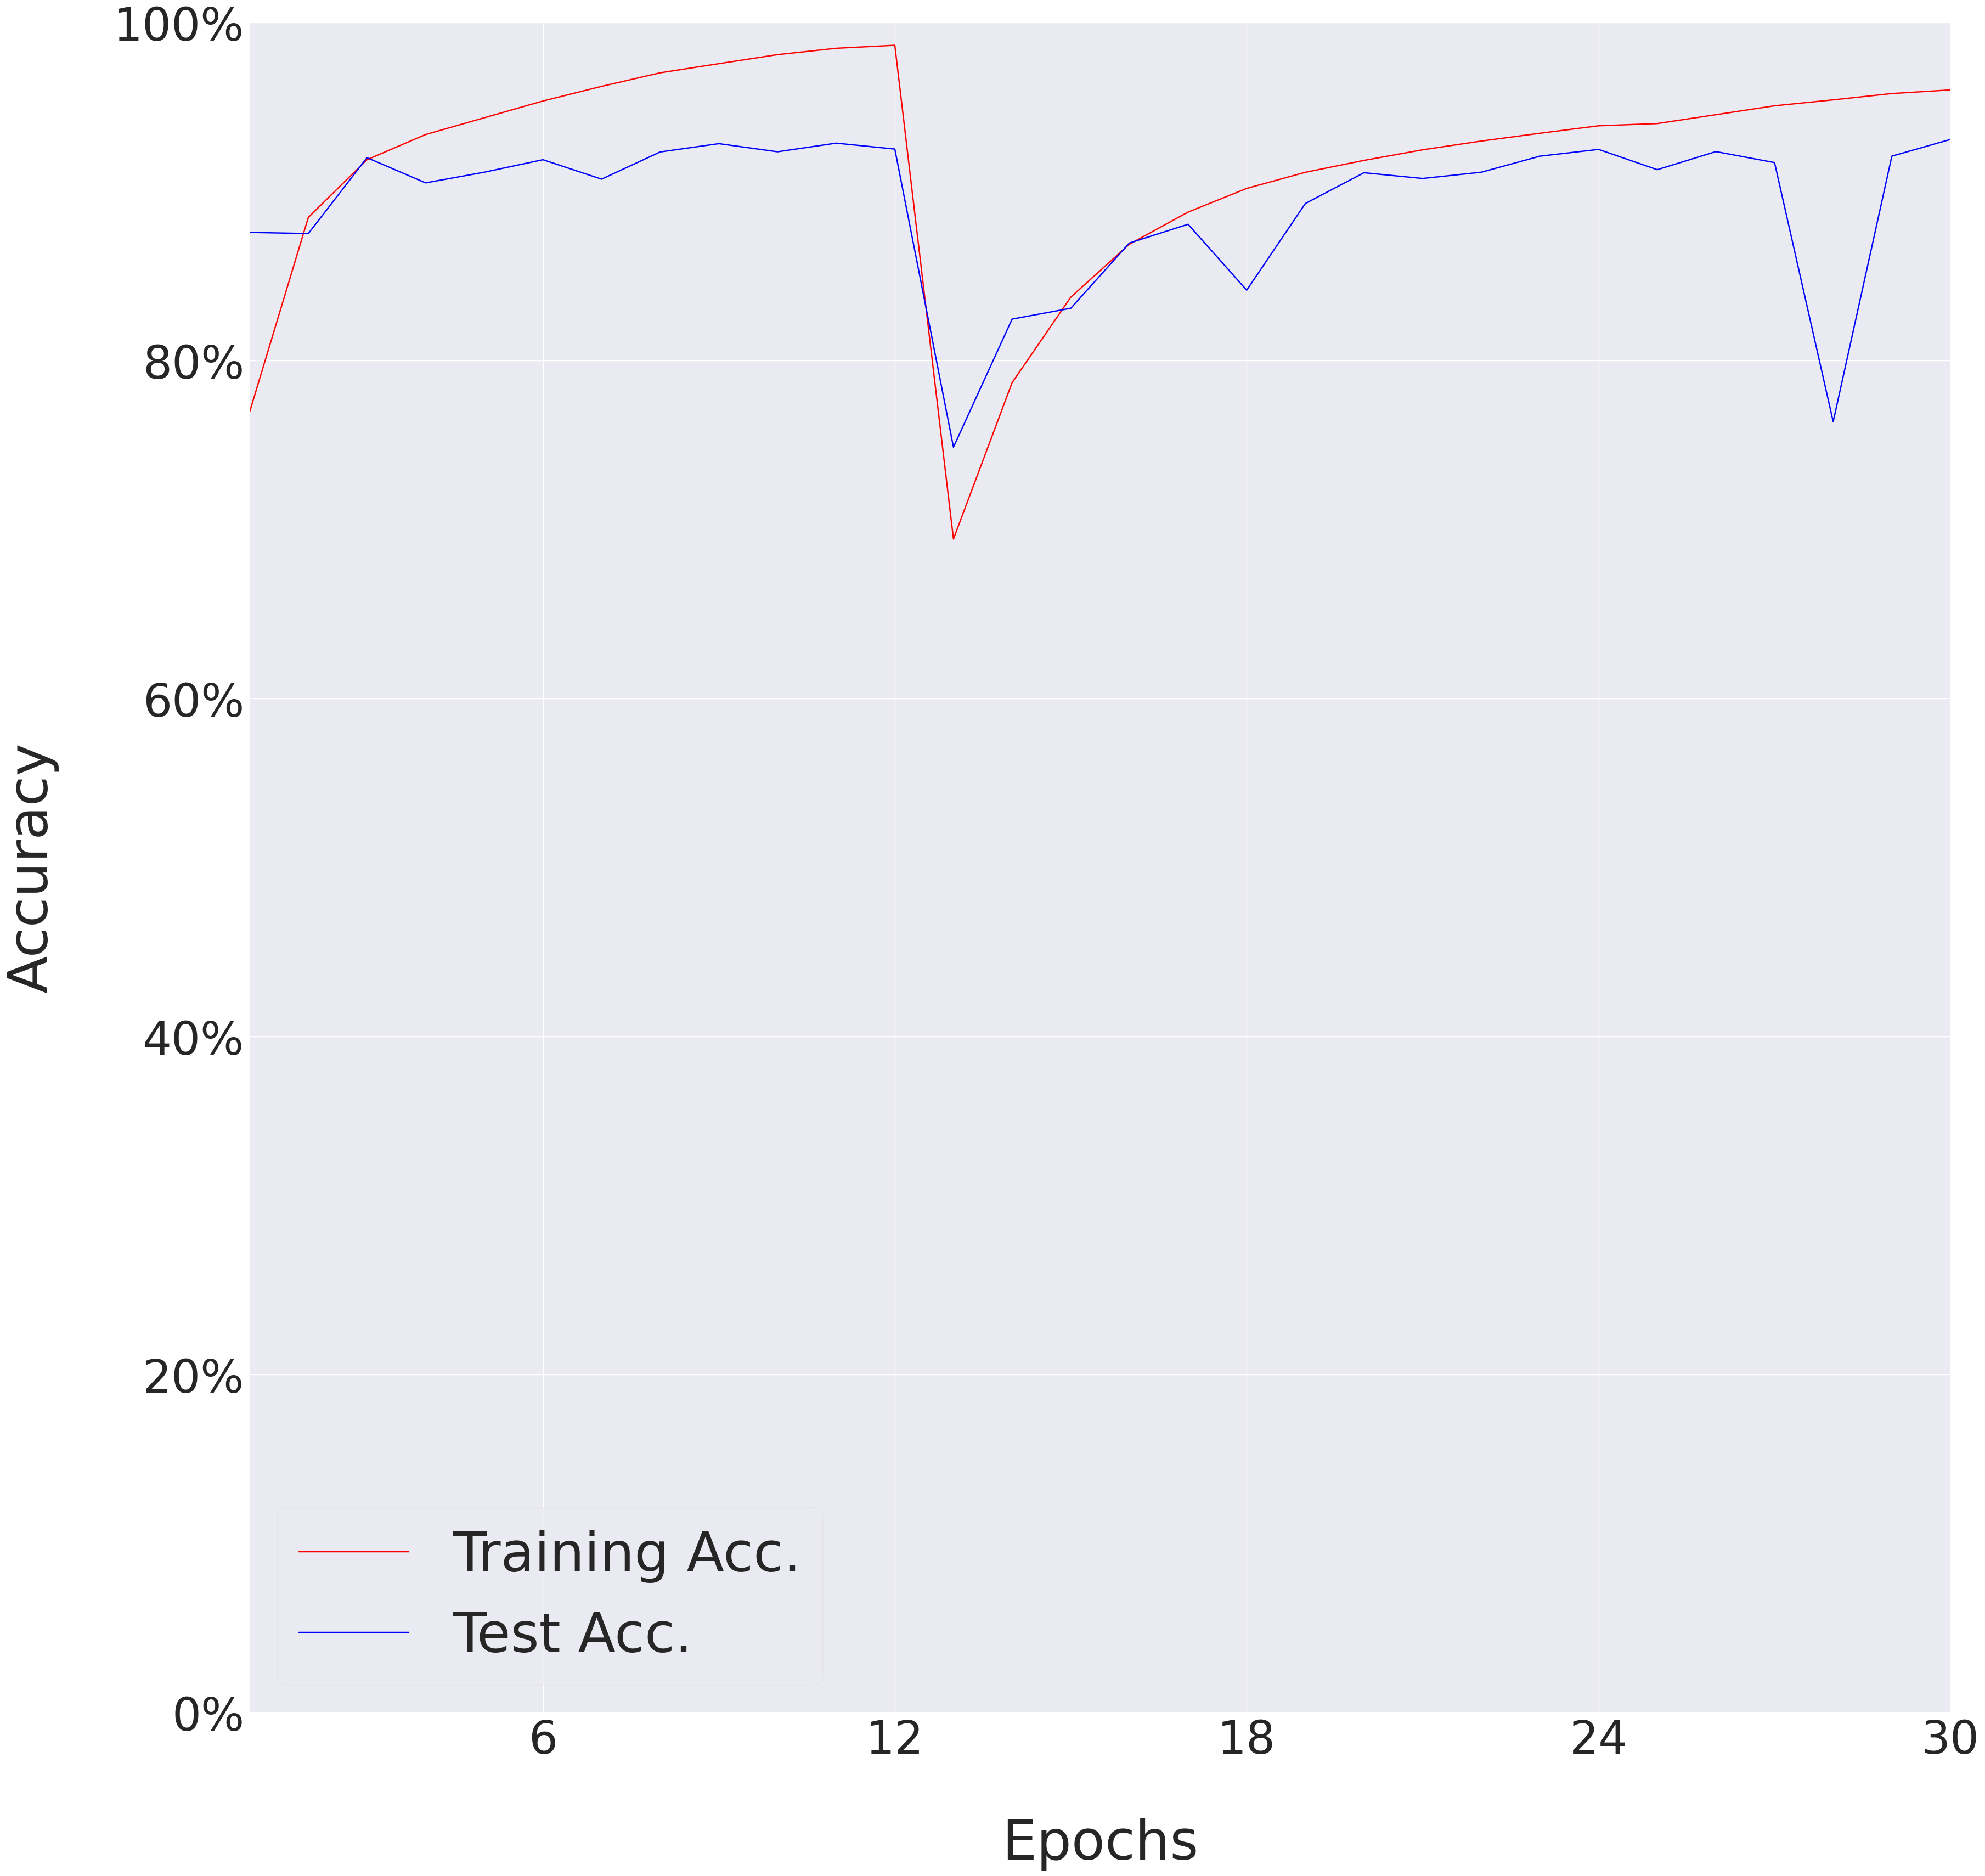

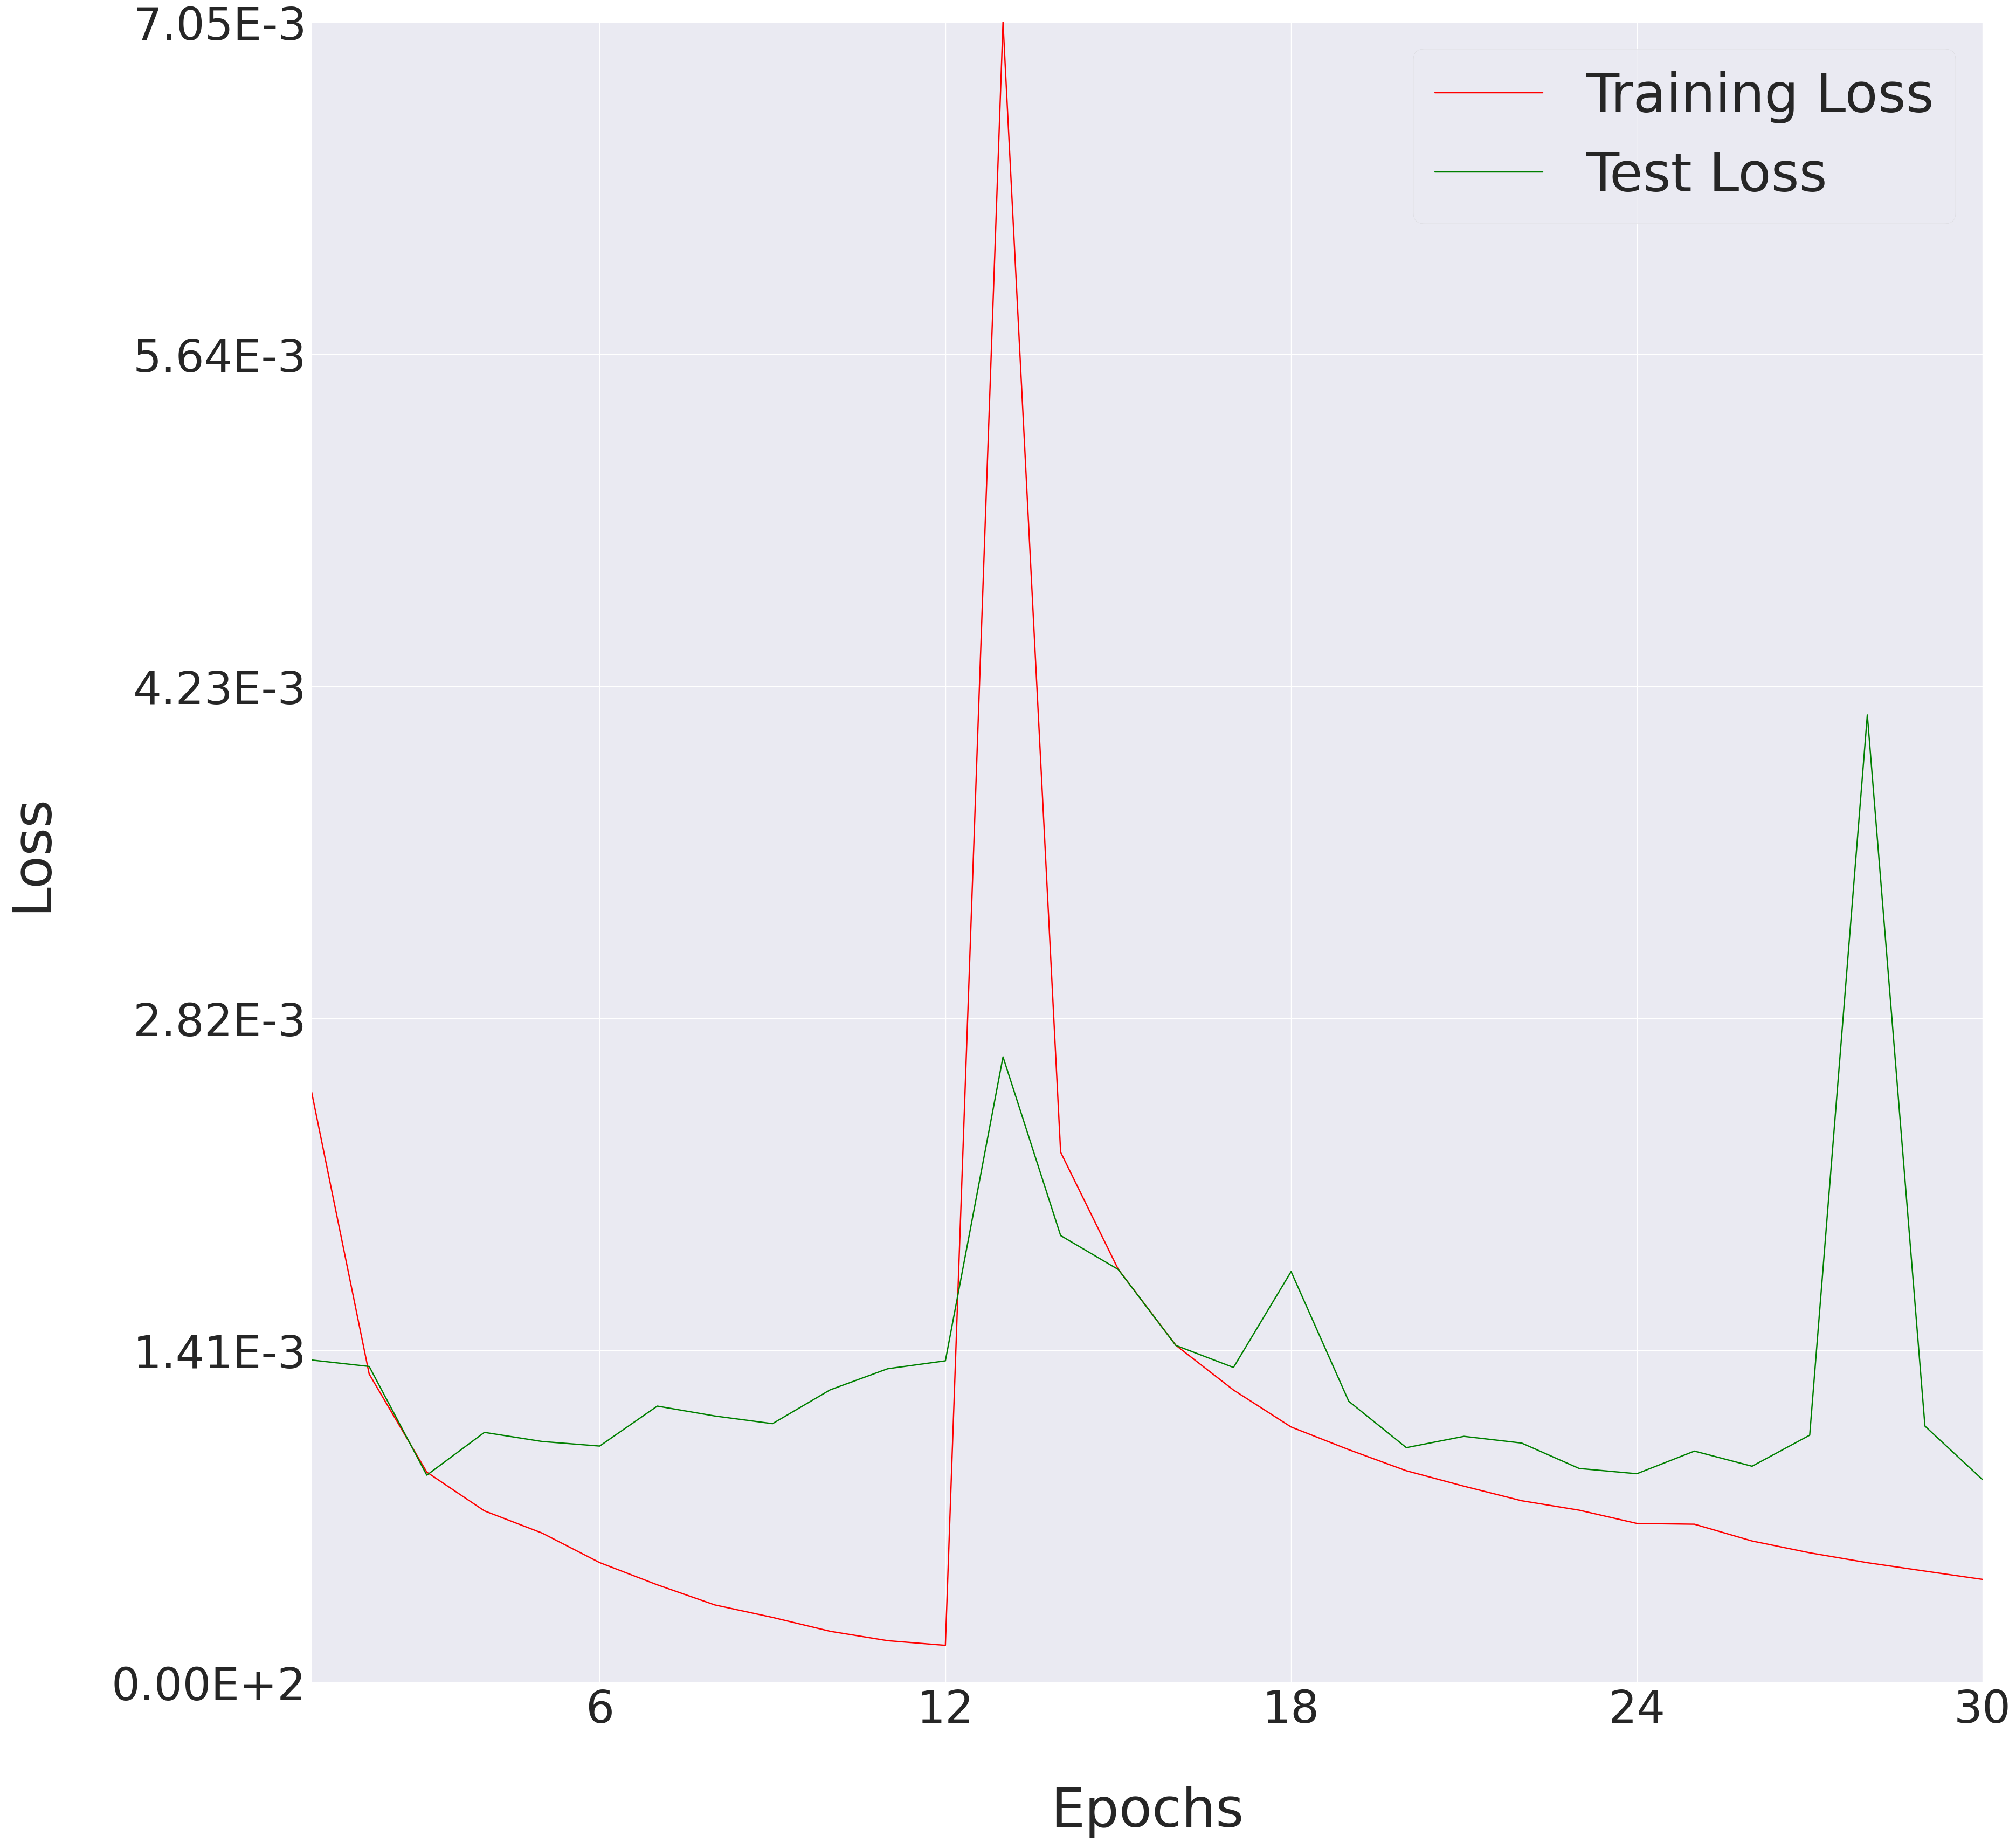

In [ ]:
import time
import os
import torch
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from torch.cuda.amp import GradScaler
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

def save(net, logger, path):

    path = path + '/last-epoch.pt'
    # Logger and net dictionary
    checkpoint = {
        'logs': logger.get_logs(),
        'params': net.state_dict()
    }

    torch.save(checkpoint, path) # Save checkpoint

if __name__ == '__main__':
    # Hyper-parameters
    learning_rate = 1e-1
    num_epochs = 30
    batch_size = 256
    model = 'VGG' # LeNet, AlexNet, VGG
    dataset = 'FashionMNIST' # FashionMNIST, CIFAR10
    experiment = 22

    path = './results/{}/{}/experiment-{}'.format(model, dataset, experiment)

    if os.path.isdir(path) == False:
      os.makedirs(path)

    logger = Logger()

    if model == 'LeNet':
        net = LeNet().to(device)
    elif model == 'AlexNet':
        net = AlexNet().to(device)
    elif model == 'VGG':
        net = VGG().to(device)

    print(net)

    # Resize images of VGG with CIFAR
    AlexTransform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])


    train_dataset = datasets.FashionMNIST(root='./data', train = True, download = True, transform = AlexTransform)
    test_dataset = datasets.FashionMNIST(root='./data', train = False, download = True, transform = AlexTransform)
    train_loader = DataLoader(train_dataset, batch_size = batch_size)
    test_loader = DataLoader(test_dataset, batch_size = batch_size)

    # Optimzer and learning rate scheduler
    optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    scaler = GradScaler()

    print('Training started...')
    for epoch in range(0, num_epochs):
        t_start = time.time()

        # Steps loops
        acc_train, loss_train = train_steps(epoch, net, train_loader, criterion, optimizer, scaler)
        acc_test, loss_test = evaluate_steps(net, test_loader, criterion)

        logger.acc_train.append(acc_train)
        logger.loss_train.append(loss_train)
        logger.acc_test.append(acc_test)
        logger.loss_test.append(loss_test)

        print('Epoch {} | Train Acc. {:.2f}% | Test Acc. {:.2f}% | Train Loss {:.5f}% | Test Loss {:.5f}%\n'.format(epoch+1, acc_train, acc_test, loss_train, loss_test))


    print('Finished training.\n')

    # Save last epoch net weights and all measures graphics
    save(net, logger, path)
    logger.save_plts(path)

Network Restored!


Accuracy: 93.09000000%
Confusion Matrix:
 [[85.9  0.   3.7  2.4  0.3  0.1  6.7  0.   0.9  0. ]
 [ 0.2 97.8  0.   1.6  0.2  0.   0.1  0.   0.1  0. ]
 [ 1.3  0.1 91.5  1.2  3.9  0.   2.   0.   0.   0. ]
 [ 0.2  0.1  0.9 96.7  1.4  0.   0.7  0.   0.   0. ]
 [ 0.   0.   2.1  3.3 91.3  0.   3.2  0.   0.1  0. ]
 [ 0.1  0.   0.   0.2  0.  97.8  0.   1.6  0.   0.3]
 [ 7.6  0.   5.5  3.6  6.   0.  76.8  0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.1  0.  98.9  0.   1. ]
 [ 0.1  0.1  0.2  0.4  0.1  0.1  0.3  0.2 98.5  0. ]
 [ 0.   0.   0.   0.2  0.   0.3  0.   3.7  0.1 95.7]] 



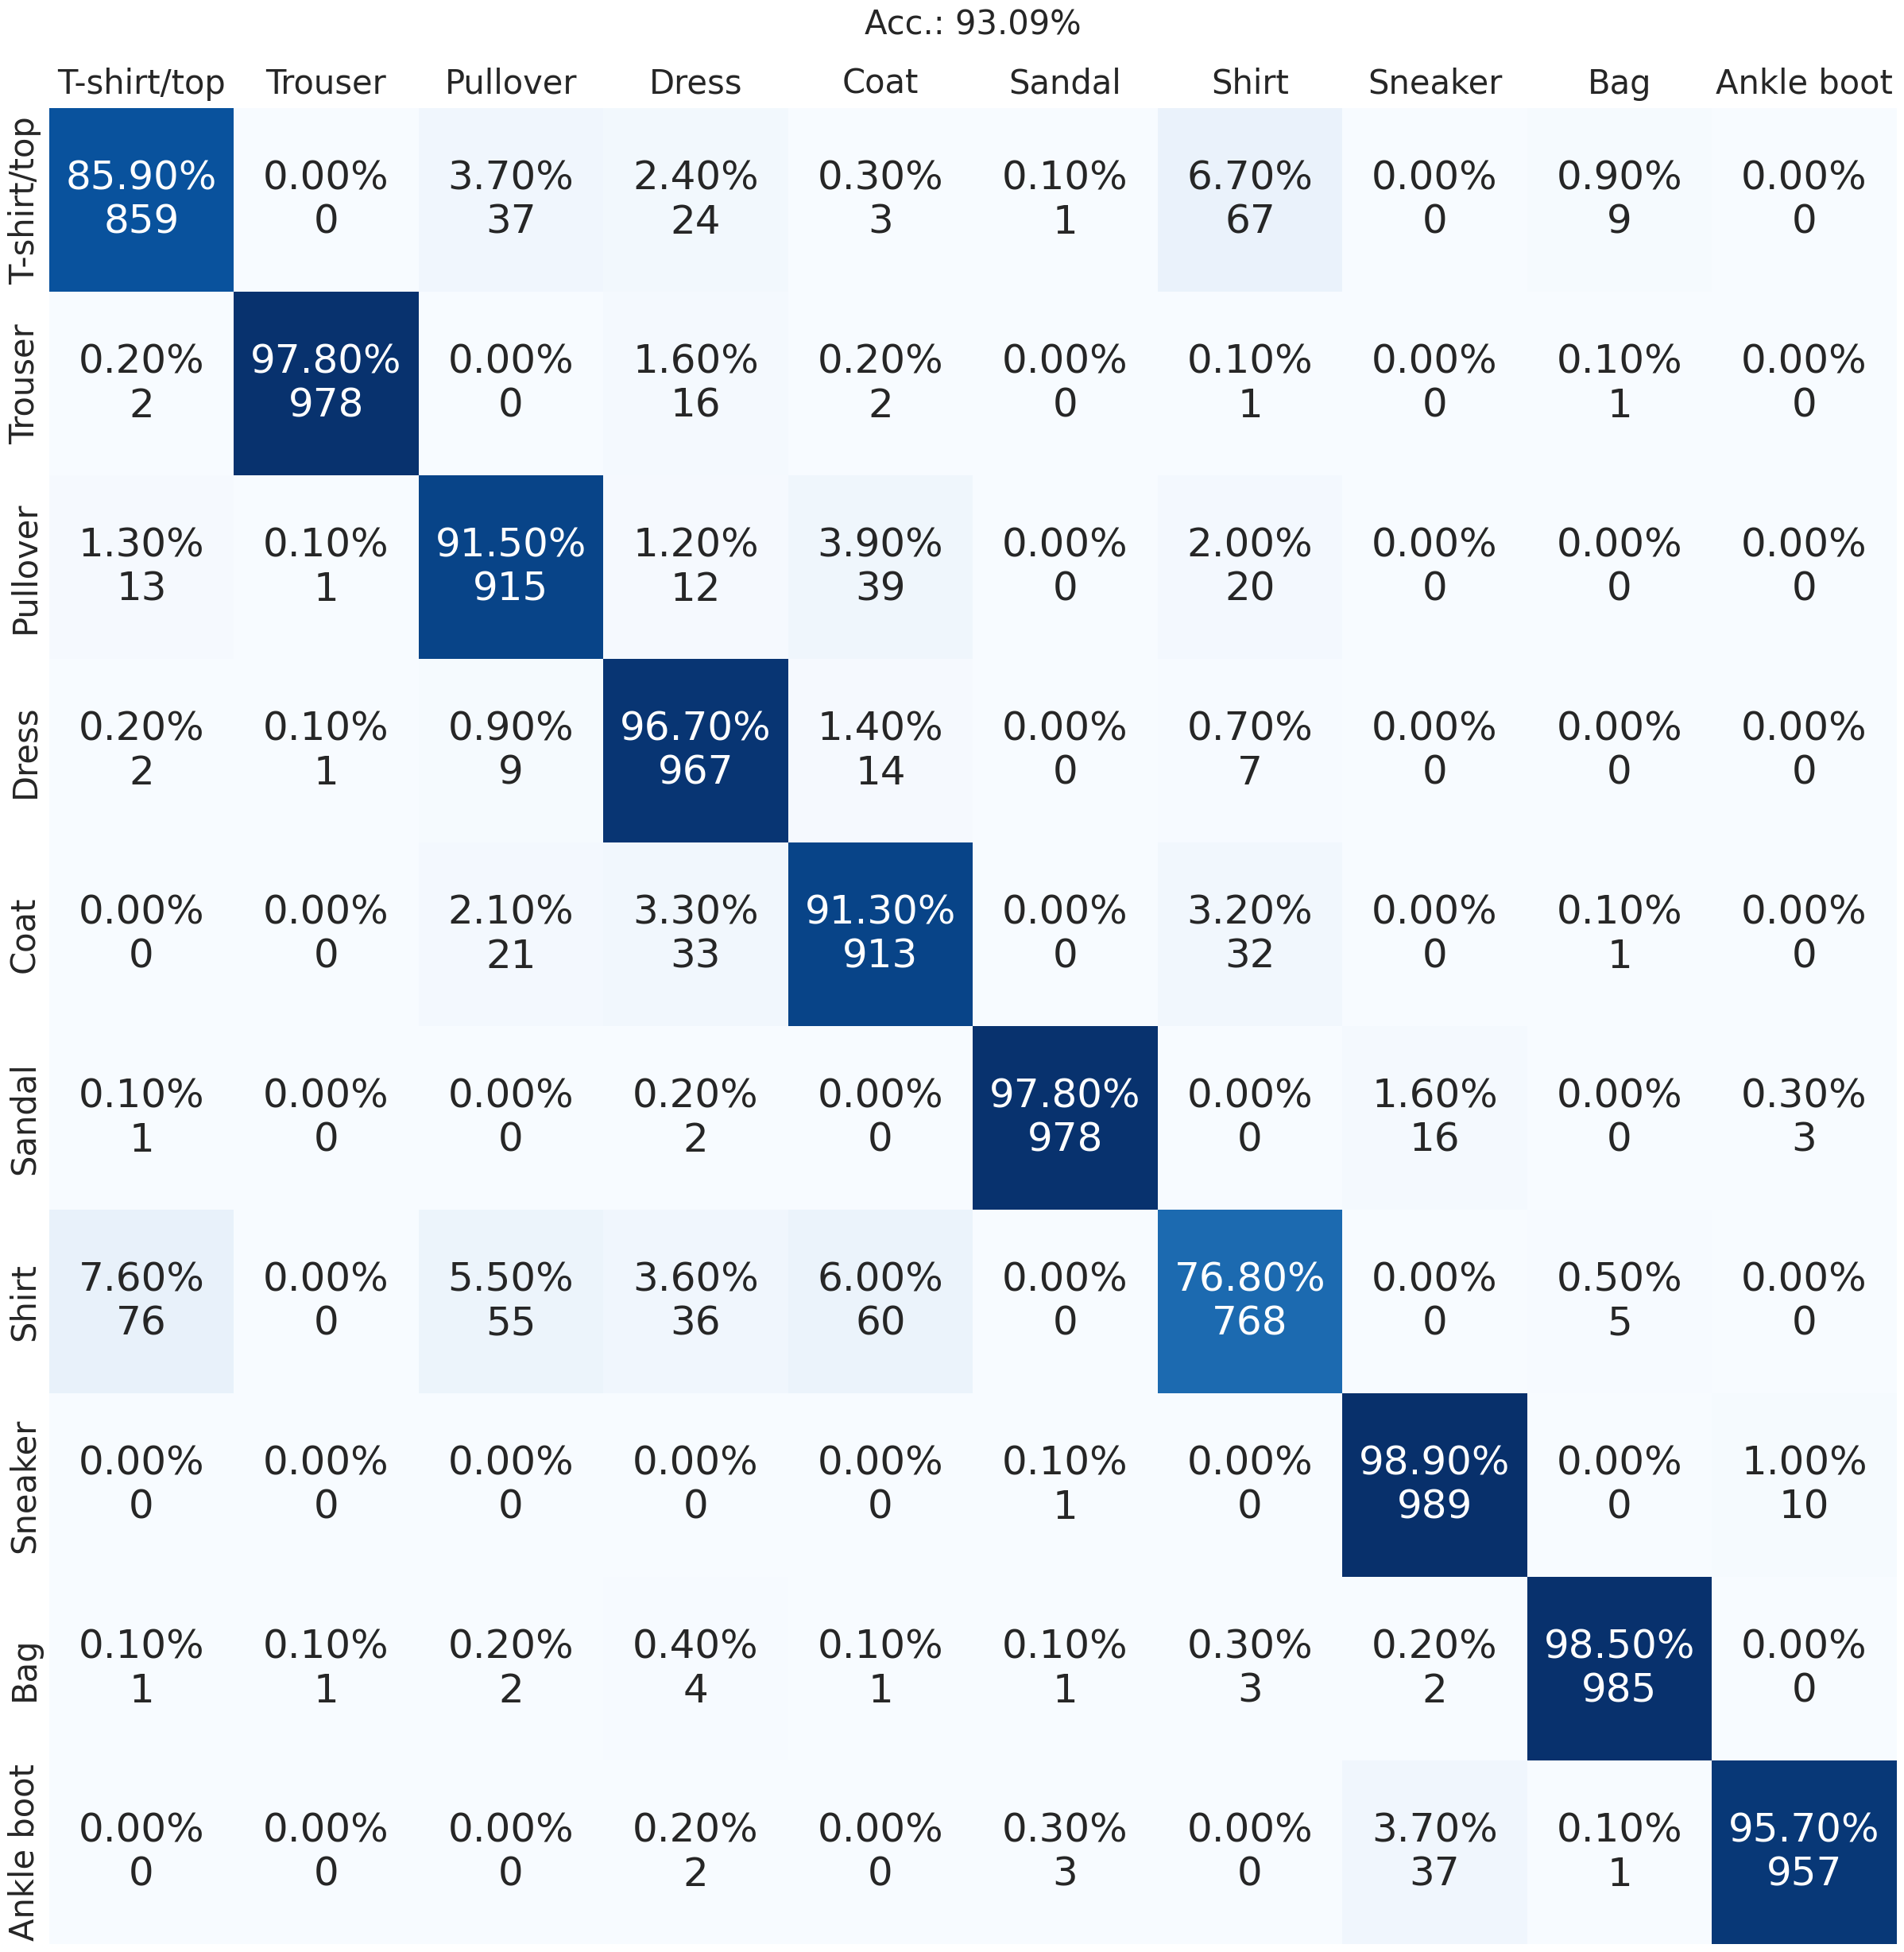

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sb

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score

device = torch.device('cpu')

def restore(net, logger, path):

    path = path + '/last-epoch.pt'

    try:
        checkpoint = torch.load(path)

        net.load_state_dict(checkpoint['params'])
        logger.restore_logs(checkpoint['logs'])

        print('Network Restored!')
    except Exception as e:
        print('Restore Failed!')
        print(e)

def evaluate(net, test_loader, dataset):

    checkpoint_save_dir = './results/{}/{}/experiment-{}'.format(model, dataset, experiment)

    num_samples = 0

    tgs_i = [] # Inputs targets
    preds_i = [] # Predictions

    with torch.no_grad(): # Disables gradient calculation
        net = net.eval()
        for test in test_loader:
            inputs, labels = test
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs) # Forward

            # Calculate performance metrics
            num_samples += labels.size(0)

            tgs_i.extend(label.item() for label in labels)
            confs = F.softmax(outputs, dim = 1)
            preds = torch.argmax(confs, 1)
            preds_i.extend(pred.item() for pred in preds)

    acc = 100*(accuracy_score(tgs_i, preds_i))
    cf_matrix_abs = confusion_matrix(tgs_i, preds_i)
    cf_matrix_rel = 100*cf_matrix_abs/cf_matrix_abs.sum(axis = 1)[:, np.newaxis]

    print('Accuracy: {:.8f}%'.format(acc))
    print('Confusion Matrix:\n', cf_matrix_rel, '\n')

    ploting_confusion_matrix(cf_matrix_abs, cf_matrix_rel, acc, checkpoint_save_dir, dataset)

    #%% MEASURES SAVE

    precision = 100*precision_score(tgs_i, preds_i, average = None)
    recall = 100*recall_score(tgs_i, preds_i, average = None)
    f1 = 100*f1_score(tgs_i, preds_i, average = None)
    f2 = 100*fbeta_score(tgs_i, preds_i, average = None, beta = 2)

    dict_metrics = {'precision': precision, 'recall': recall, 'f1': f1, 'f2': f2}
    df_metrics = pd.DataFrame(dict_metrics)
    df_metrics.to_csv('{}/measures_last-epoch.csv'.format(checkpoint_save_dir), index = False)

#%% CONFUSION MATRIX PLOT

def ploting_confusion_matrix(cf_matrix_abs, cf_matrix_rel, acc, checkpoint_save_dir, dataset):
    plt.rcParams.update({
        'text.usetex': False,
        'font.family': 'serif',
        'font.serif': ['Times']
    })

    if dataset == 'FashionMNIST':
        classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    elif dataset == 'CIFAR10':
        classes_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    cf_matrix_path = os.path.join(checkpoint_save_dir, 'cf_matrix.pdf')

    group_counts = ['{0:.0f}'.format(value) for value in cf_matrix_abs.flatten()] # Confusion matrix with absolute values

    group_percentages = ['{0:.2f}'.format(value) for value in cf_matrix_rel.flatten()] # Confusion matrix with relative values

    # Confusion matrix with both absolute and relative values
    annot = [f'{v1}' + r'%' + f'\n{v2}' for v1, v2 in zip(group_percentages, group_counts)]
    annot = np.asarray(annot).reshape(len(classes_names) , len(classes_names))

    # Ploting
    _, ax = plt.subplots(1, figsize = (30, 30))

    sb.set(rc = {'text.usetex': False, 'font.family': 'serif', 'font.serif': ['Times']}, font_scale = 3)
    ax = sb.heatmap(cf_matrix_rel,
                    xticklabels = classes_names,
                    yticklabels = classes_names,
                    annot = annot,
                    fmt = '',
                    cmap = 'Blues',
                    cbar = False)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length = 0)

    plt.xlabel('Acc.: {:.2f}'.format(acc) + r'%', labelpad = 30, fontsize = 30)

    plt.xticks(plt.xticks()[0], [label._text for label in plt.xticks()[1]], fontsize = 30)

    plt.yticks(plt.yticks()[0], [label._text for label in plt.yticks()[1]], fontsize = 30, rotation = 90)

    plt.savefig(cf_matrix_path, bbox_inches = 'tight', pad_inches = 0)

if __name__ == '__main__':
    # Build network (last epoch)

    model = 'VGG' # LeNet, AlexNet, VGG
    dataset = 'FashionMNIST' # FashionMNIST, CIFAR10
    experiment = 22
    path =  './results/{}/{}/experiment-{}'.format(model, dataset, experiment)

    logger = Logger()

    if model == 'LeNet':
        net = LeNet().to(device) # Put on GPU
    elif model == 'AlexNet':
        net = AlexNet().to(device) # Put on GPU
    elif model == 'VGG':
        net = VGG().to(device) # Put on GPU

    restore(net, logger, path)


    AlexTransform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

    train_dataset = datasets.FashionMNIST(root='./data', train = True, download = False, transform = AlexTransform)
    test_dataset = datasets.FashionMNIST(root='./data', train = False, download = False, transform = AlexTransform)
    test_loader = DataLoader(test_dataset)

    evaluate(net, test_loader, dataset)